In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.network_builder import NetworkBuilder
from hnn_core.cell import _get_gaussian_connection
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import utils
from utils import (SingleNeuron_Data, Network_Data, CellType_Dataset_Fast,
                   linear_scale_forward, log_scale_forward, UniformPrior, beta_tuning_param_function)
import multiprocessing
from typing import Dict, Tuple, Optional, List

device = torch.device("cuda:0")
# device = 'cpu'
num_cores = multiprocessing.cpu_count()
torch.backends.cudnn.enabled = True

In [2]:
# Set up prior distribution
prior_dict = {'EI_gscale': {'bounds': (-2, 2), 'rescale_function': log_scale_forward},
              'EE_gscale': {'bounds': (-2, 1), 'rescale_function': log_scale_forward},
              'II_gscale': {'bounds': (-2, 2), 'rescale_function': log_scale_forward},
              'IE_gscale': {'bounds': (-2, 2), 'rescale_function': log_scale_forward},
              'EI_prob': {'bounds': (0, 1), 'rescale_function': linear_scale_forward},
              'EE_prob': {'bounds': (0, 1), 'rescale_function': linear_scale_forward},
              'II_prob': {'bounds': (0, 1), 'rescale_function': linear_scale_forward},
              'IE_prob': {'bounds': (0, 1), 'rescale_function': linear_scale_forward},
              'L2e_distal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L2i_distal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L5e_distal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L5i_distal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L2e_proximal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L2i_proximal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L5e_proximal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              'L5i_proximal': {'bounds': (-4, 0), 'rescale_function': log_scale_forward},
              }

prior = UniformPrior(parameters=list(prior_dict.keys()))

In [91]:
# Instiatiate network and collect connectivity data

hnn_core_root = op.dirname(hnn_core.__file__)
params_fname = op.join(hnn_core_root, 'param', 'default.json')
params = read_params(params_fname)
# params.update({'N_pyr_x': 3, 'N_pyr_y': 3})

net = calcium_model(params)


# Extract all E-I connection types
E_gids = np.concatenate([net.gid_ranges['L2_pyramidal'], net.gid_ranges['L5_pyramidal']]).tolist()
I_gids = np.concatenate([net.gid_ranges['L2_basket'], net.gid_ranges['L5_basket']]).tolist()

EI_connections = pick_connection(net, src_gids=E_gids, target_gids=I_gids)
EE_connections = pick_connection(net, src_gids=E_gids, target_gids=E_gids)
II_connections = pick_connection(net, src_gids=I_gids, target_gids=I_gids)
IE_connections = pick_connection(net, src_gids=I_gids, target_gids=E_gids)

# Store in dictionary to be added to theta_dict
theta_extra = {'EI_connections': EI_connections, 'EE_connections': EE_connections, 
               'II_connections': II_connections, 'IE_connections': IE_connections,
               'lamtha': 4.0}
theta_extra['sample_idx'] =  0

# Update network parameters
thetai = torch.tensor(np.repeat(0.6, len(prior_dict)))
theta_dict = {param_name: param_dict['rescale_function'](thetai[param_idx].numpy(), param_dict['bounds']) for 
                param_idx, (param_name, param_dict) in enumerate(prior_dict.items())}

theta_dict['theta_extra'] = theta_extra

beta_tuning_param_function(net, theta_dict, rate=10)

In [92]:
%%capture
net_drive = net.copy()
net_drive.clear_connectivity()
net_connectivity = net_big.copy()
_ = simulate_dipole(net_drive, dt=0.5, tstop=1000, record_vsec='all', record_isec='all', record_dcell=True)
_ = simulate_dipole(net_connectivity, dt=0.5, tstop=1, record_vsec='all', record_isec='all', record_dcell=True)

network_data_drive = Network_Data(net_drive, soma_filter=True)
network_data_connectivity = Network_Data(net_connectivity, soma_filter=True)

In [93]:
# Make input spike dict initialized with prox/distal noisy drive
input_spike_dict = dict()
for cell_type in net.cell_types:
    gid_list = net.gid_ranges[cell_type]
    input_spike_dict[cell_type] = np.stack([network_data_drive.input_spike_dict[gid].T for gid in gid_list])

In [94]:
dataset_type = 'connected'
dataset_indices = [0]

model_architecture = {'L5_pyramidal': {'hidden_dim': 64, 'n_layers': 5},
                      'L2_pyramidal': {'hidden_dim': 64, 'n_layers': 5},
                      'L5_basket': {'hidden_dim': 8, 'n_layers': 2},
                      'L2_basket': {'hidden_dim': 8, 'n_layers': 2}}

model_dict, dataset_dict = dict(), dict()
for cell_type in net.cell_types:
    cell_type_dataset = torch.utils.data.ConcatDataset(
        [torch.load(f'datasets_{dataset_type}/training_data/{cell_type}_dataset_{idx}.pt') for
         idx in dataset_indices])
    dataset_dict[cell_type] = cell_type_dataset

    _, input_size = cell_type_dataset[0][0].detach().cpu().numpy().shape
    _, output_size = cell_type_dataset[0][1].detach().cpu().numpy().shape

    model_dict[cell_type] = utils.model_celltype_lstm(
        input_size=input_size, output_size=output_size, device=device, **model_architecture[cell_type])
    model_dict[cell_type].load_state_dict(torch.load(f'{dataset_type}_models/{cell_type}_{dataset_type}_model.pt'))
    model_dict[cell_type].to(device)

In [95]:
# m = torch.jit.script(utils.model_celltype_lstm())


In [96]:
#LSTM/GRU architecture for decoding
class model_network(nn.Module):
    def __init__(self, net, model_dict, dataset_dict, network_data, device='cuda:0', bidirectional=False):
        super(model_network, self).__init__()
        self.net = net
        # self.model_dict = model_dict
        self.L5pyr_model: torch.Module = model_dict['L5_pyramidal']
        self.L2pyr_model: torch.Module = model_dict['L2_pyramidal']
        self.L5basket_model: torch.Module = model_dict['L5_basket']
        self.L2basket_model: torch.Module = model_dict['L2_basket']   
        self.gid_ranges: Dict[str, np.ndarray] = {cell_type: list(gid_range) for cell_type, gid_range in net.gid_ranges.items()}

        self.kernel_size = model_dict['L5_pyramidal'].kernel_size
        self.output_size_dict: Dict[str, int] = {cell_type: model_dict[cell_type].output_size for cell_type in net.cell_types}
        
        self.EI_dict: Dict[str, torch.Tensor] = self.make_EI_dict()

        self.dataset_dict = dataset_dict
        self.network_data = network_data
        self.connectivity_dict = network_data.connectivity_dict.copy()
        for cell_type, conn in self.connectivity_dict.items():
            self.connectivity_dict[cell_type] = torch.from_numpy(conn).float().to(device).requires_grad_(True)

        self.delay_matrix = network_data.delay_matrix

        self.scaler_dict: Dict[str, Dict[str, torch.Tensor]] = self.get_spike_scaler()

        self.soma_idx = 0
        self.threshold_dict = self.get_thresholds()

        self.device = device

    def make_EI_dict(self):
        EI_dict = dict()
        out_spikes_dict = dict()
        for src_type in net.cell_types:
            out_spikes_dict
            for target_type in net.cell_types:
                EI_dict[f'{src_type}_{target_type}'] = nn.Parameter(torch.tensor(1.0))
        return EI_dict

    @torch.jit.export
    def scale_spikes(self, input_spikes: torch.Tensor, cell_type: str) -> torch.Tensor:
        input_spikes = input_spikes * self.scaler_dict[cell_type]['spike_scale']
        input_spikes = input_spikes + self.scaler_dict[cell_type]['spike_min']
        return input_spikes

    def get_thresholds(self):
        threshold_dict = dict()
        for cell_type in self.net.cell_types:
            threshold = (self.net.threshold - self.scaler_dict[cell_type]['vsec_mean'][self.soma_idx]) / \
                self.scaler_dict[cell_type]['vsec_scale'][self.soma_idx]
            threshold_dict[cell_type] = threshold

        return threshold_dict

    @torch.jit.export
    def get_out_spikes(self, input_spike_dict: Dict[str, torch.Tensor], cell_types: List[str]) -> Dict[str, Dict[str, List[torch.Tensor]]]:
        out_spikes_dict = dict()
        for src_type in cell_types:
            out_spikes_dict[src_type] = dict()
            for target_type in cell_types:
                out_spikes_dict[src_type][target_type] = [
                    torch.zeros((input_spike_dict[target_type].size(0), input_spike_dict[target_type].size(2))).to(self.device) for 
                    _ in range(self.kernel_size)]

        return out_spikes_dict

    def forward(self, L5pyr_spikes: torch.Tensor, L2pyr_spikes: torch.Tensor,
                L5basket_spikes: torch.Tensor, L2basket_spikes: torch.Tensor) -> \
                    Tuple[List[torch.Tensor], List[torch.Tensor], List[torch.Tensor], List[torch.Tensor]]:
        input_spikes_dict: Dict[str, torch.Tensor] = {'L5_pyramidal': L5pyr_spikes.requires_grad_(True), 'L2_pyramidal': L2pyr_spikes.requires_grad_(True),
                                                      'L5_basket': L5basket_spikes.requires_grad_(True), 'L2_basket': L2basket_spikes.requires_grad_(True)}
 
        cell_names = ['L5_pyramidal', 'L2_pyramidal', 'L5_basket', 'L2_basket']

        h0_L5basket = torch.zeros(self.L5basket_model.n_layers, L5basket_spikes.size(0), self.L5basket_model.hidden_dim).to(self.device)
        c0_L5basket = h0_L5basket.clone()

        h0_L2basket = torch.zeros(self.L2basket_model.n_layers, L2basket_spikes.size(0), self.L2basket_model.hidden_dim).to(self.device)
        c0_L2basket = h0_L2basket.clone()

        h0_L5pyr = torch.zeros(self.L5pyr_model.n_layers, L5pyr_spikes.size(0), self.L5pyr_model.hidden_dim).to(self.device)
        c0_L5pyr = h0_L5pyr.clone()

        h0_L2pyr = torch.zeros(self.L2pyr_model.n_layers, L2pyr_spikes.size(0), self.L2pyr_model.hidden_dim).to(self.device)
        c0_L2pyr = h0_L2pyr.clone()
        
        pred_y_dict = {cell_type: [torch.zeros((input_spikes_dict[cell_type].size(0), self.output_size_dict[cell_type],)).to(self.device),
                                   torch.zeros((input_spikes_dict[cell_type].size(0), self.output_size_dict[cell_type],)).to(self.device)] for cell_type in cell_names}
        
        out_spikes_dict: Dict[str, Dict[str, List[torch.Tensor]]] = self.get_out_spikes(input_spikes_dict, cell_names)

        for time_idx in range(self.kernel_size, input_spikes_dict['L5_basket'].size(1)-1000):

            batch_x = input_spikes_dict['L5_basket'][:, time_idx-self.L5pyr_model.kernel_size:time_idx, :]
            batch_x = batch_x + \
                torch.stack([torch.stack(out_spikes_dict[cell_type]['L5_basket'][-self.kernel_size:], axis=1) for
                    cell_type in cell_names]).sum(axis=0)
            out_L5_basket = self.scale_spikes(batch_x, 'L5_basket')
            out_L5_basket, h0_L5basket, c0_L5basket = self.L5basket_model(out_L5_basket, h0_L5basket, c0_L5basket)            
            pred_y_dict['L5_basket'].append(out_L5_basket[:,-1, :])

            batch_x = input_spikes_dict['L2_basket'][:, time_idx-self.L2pyr_model.kernel_size:time_idx, :]
            batch_x = batch_x + \
                torch.stack([torch.stack(out_spikes_dict[cell_type]['L2_basket'][-self.kernel_size:], axis=1) for
                    cell_type in cell_names]).sum(axis=0)
            out_L2_basket = self.scale_spikes(batch_x, 'L2_basket')
            out_L2_basket, h0_L2basket, c0_L2basket = self.L2basket_model(out_L2_basket, h0_L2basket, c0_L2basket)
            pred_y_dict['L2_basket'].append(out_L2_basket[:,-1, :])

            batch_x = input_spikes_dict['L5_pyramidal'][:, time_idx-self.L5pyr_model.kernel_size:time_idx, :]
            batch_x = batch_x + \
                torch.stack([torch.stack(out_spikes_dict[cell_type]['L5_pyramidal'][-self.kernel_size:], axis=1) for
                    cell_type in cell_names]).sum(axis=0)
            out_L5_pyr = self.scale_spikes(batch_x, 'L5_pyramidal')
            out_L5_pyr, h0_L5pyr, c0_L5pyr = self.L5pyr_model(out_L5_pyr, h0_L5pyr, c0_L5pyr)
            pred_y_dict['L5_pyramidal'].append(out_L5_pyr[:,-1, :])

            batch_x = input_spikes_dict['L2_pyramidal'][:, time_idx-self.L2pyr_model.kernel_size:time_idx, :]
            batch_x = batch_x + \
                torch.stack([torch.stack(out_spikes_dict[cell_type]['L2_pyramidal'][-self.kernel_size:], axis=1) for
                    cell_type in cell_names]).sum(axis=0)
            out_L2_pyr = self.scale_spikes(batch_x, 'L2_pyramidal')
            out_L2_pyr, h0_L2pyr, c0_L2pyr = self.L2pyr_model(out_L2_pyr, h0_L2pyr, c0_L2pyr)
            pred_y_dict['L2_pyramidal'].append(out_L2_pyr[:,-1, :])

            for cell_type in cell_names:
                spike_mask = ((pred_y_dict[cell_type][-1][:, self.soma_idx] > self.threshold_dict[cell_type]) & \
                    (pred_y_dict[cell_type][-2][:, self.soma_idx] < self.threshold_dict[cell_type])).float().requires_grad_(True)
                            
                for target_type in cell_names:
                    out_spikes = torch.matmul(self.connectivity_dict[target_type][:, :, self.gid_ranges[cell_type]],
                                     spike_mask * self.EI_dict[f'{cell_type}_{target_type}'])
                    out_spikes_dict[cell_type][target_type].append(out_spikes)

                
        return (pred_y_dict['L5_pyramidal'], pred_y_dict['L2_pyramidal'], pred_y_dict['L5_basket'], pred_y_dict['L2_basket'])

    def get_spike_scaler(self):
        scaler_dict = dict()
        for cell_type in self.net.cell_types:
            scaler_dict[cell_type] = {
                'spike_min': torch.tensor(self.dataset_dict[cell_type].datasets[0].input_spike_scaler.min_).float().to(device),
                'spike_scale': torch.tensor(self.dataset_dict[cell_type].datasets[0].input_spike_scaler.scale_).float().to(device),
                'vsec_mean': torch.tensor(self.dataset_dict[cell_type].datasets[0].vsec_scaler.mean_).float().to(device),
                'vsec_scale': torch.tensor(self.dataset_dict[cell_type].datasets[0].vsec_scaler.scale_).float().to(device),
            }

        return scaler_dict



 

In [107]:
model_pytorch = model_network(net, model_dict, dataset_dict, network_data_connectivity, device=device, bidirectional=False)

In [108]:
# model = torch.jit.script(model_pytorch).to(device)
model = model_pytorch.to(device)

In [109]:
# Make input spike dict initialized with prox/distal noisy drive
input_spike_dict = dict()
for cell_type in net.cell_types:
    gid_list = net.gid_ranges[cell_type]
    input_spike_dict[cell_type] = torch.from_numpy(
        np.stack([network_data_drive.input_spike_dict[gid].T for gid in gid_list])).float().to(device)


RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 5.78 GiB total capacity; 2.71 GiB already allocated; 21.12 MiB free; 4.57 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [110]:
with torch.no_grad():
    model.eval()
    pred = model(input_spike_dict['L5_pyramidal'], input_spike_dict['L2_pyramidal'],
                        input_spike_dict['L5_basket'], input_spike_dict['L2_basket'])


KeyError: 'L5_pyramidal'

In [103]:
# model.train()
# pred = model(input_spike_dict['L5_pyramidal'], input_spike_dict['L2_pyramidal'],
#                     input_spike_dict['L5_basket'], input_spike_dict['L2_basket'])



In [104]:
dpl = torch.stack(pred[0])[:,:,1].mean(axis=1) + torch.stack(pred[1])[:,:,1].mean(axis=1)

out_fft = torch.fft.rfft(dpl).abs()
freq = torch.fft.rfftfreq(dpl.size(0), 0.5 / 1e3)


power = torch.sum(out_fft[torch.logical_and(freq > 25, freq < 30)])
total_power = torch.sum(out_fft[torch.logical_and(freq > 1, freq < 100)])

relative_power = - (power / total_power)

(0.0, 300.0)

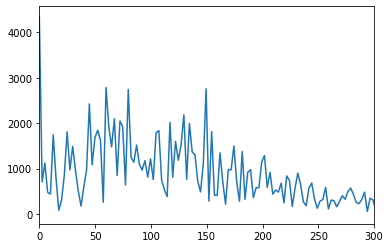

In [105]:
plt.plot(freq.detach().cpu().numpy(), out_fft.detach().cpu().numpy())
plt.xlim(0, 300)

In [106]:
relative_power.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
model.EI_dict['L5_pyramidal_L5_basket'].grad

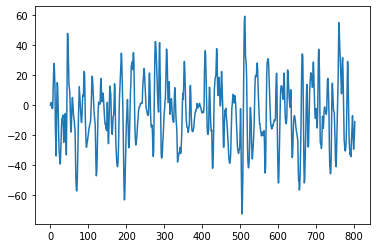

In [64]:
plt.plot(dpl.detach().cpu().numpy())

In [65]:
# from torch.profiler import profile, record_function, ProfilerActivity

# with profile(activities=[
#         ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#     with record_function("model_inference"):
#         pred_dict = model(input_spike_dict['L5_pyramidal'], input_spike_dict['L2_pyramidal'],
#                         input_spike_dict['L5_basket'], input_spike_dict['L2_basket'])

In [66]:
# print(prof.key_averages().table(sort_by="cpu_time_total"))

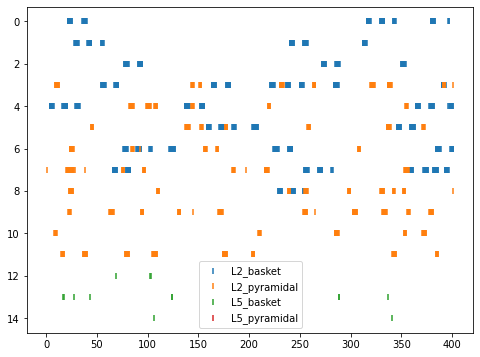

In [67]:
plt.figure(figsize=(8, 6))
for idx, cell_type in enumerate(net.cell_types):
    out = torch.stack(pred[idx]).detach().cpu().numpy()
    cell_spikes = out > model.threshold_dict[cell_type].detach().cpu().numpy()
    cell_spike_indices = np.where(cell_spikes > 0)
    offset =  list(net.gid_ranges[cell_type])[0]

    plt.scatter(cell_spike_indices[0] * 0.5, cell_spike_indices[1] + offset, c=f'C{idx}', marker='|', label=cell_type)

# flip y axis
plt.gca().invert_yaxis()
plt.legend()
   

# plt.figure(figsize=(10, 5))
# plt.scatter(inhib_spikes[1] * dt, inhib_spikes[0], c='C0', marker='|', label='Inhib')
# plt.scatter(L5pyr_spikes[1] * dt, L5pyr_spikes[0], c='C3', marker='|', label='L5pyr')
# plt.xlim(0, None)
# plt.legend()
# plt.xlabel('Time (ms)')
    

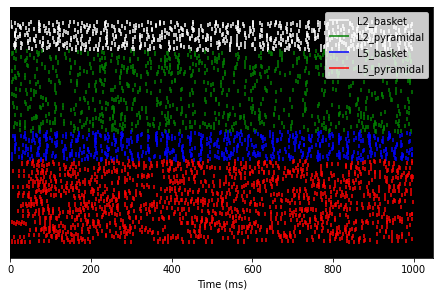

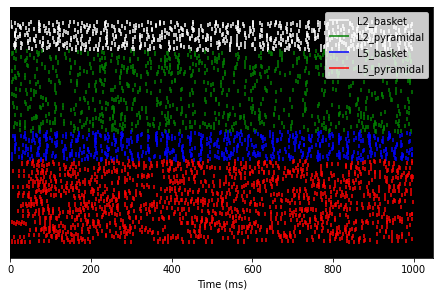

In [45]:
net_connectivity.cell_response.plot_spikes_raster()

In [27]:

out = torch.stack(pred_dict[cell_type]).detach().cpu().numpy()


In [28]:
plt.imshow(network_data.connectivity_dict['L2_basket'].numpy().sum(axis=1), aspect='auto')
plt.colorbar()

NameError: name 'network_data' is not defined

In [ ]:
network_data.neuron_data_dict[0].isec_array.shape

(3, 21)

In [ ]:
# weight_tensor = torch.from_numpy(weight_matrix).clone().detach().to(device).requires_grad_(True)
# weight_param = nn.ParameterList([weight_matrix.clone()]).to(device)

lr = 1
weight_decay = 0

# Create Gradient mask
# gradient_mask = torch.zeros(model.weight_matrix.size()).to(device)
# gradient_mask[model.weight_matrix > 0] = 1.0
# model.weight_matrix.register_hook(lambda grad: grad.mul_(gradient_mask))

optimizer = torch.optim.Adam([model.weight_matrix], lr=lr, weight_decay=weight_decay)


In [ ]:
print_freq = 10

max_epochs = 1000

input_spikes_init = model.init_input_spikes(n_samples=1000)
losses = list()
for epoch in range(max_epochs):
    # L5pyr_model.train()
    model.train()
    optimizer.zero_grad()
    input_spikes = input_spikes_init.clone().to(device).requires_grad_(False)

    pred_y = model(input_spikes)

    avg_soma = torch.mean(pred_y, axis=1)
    out_fft = torch.fft.rfft(avg_soma).abs()
    freq = torch.fft.rfftfreq(pred_y.size(0), dt / 1e3)


    power = torch.sum(out_fft[torch.logical_and(freq > 25, freq < 30)])
    total_power = torch.sum(out_fft[torch.logical_and(freq > 1, freq < 100)])

    relative_power = - (power / total_power)
    # relative_power = - power
    losses.append(relative_power.item())

    relative_power.backward()
    optimizer.step()

    #Print Loss Scores
    if (epoch+1)%print_freq == 0:
        print('')
        print('Epoch: {}/{} ...'.format(epoch+1, max_epochs), end=' ')
        print('Relative Power: {:.4f}'.format(-relative_power))

    else:
        print('*', end='')


RuntimeError: CUDA out of memory. Tried to allocate 42.00 MiB (GPU 0; 5.78 GiB total capacity; 4.34 GiB already allocated; 66.31 MiB free; 4.50 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

(0.0, 100.0)

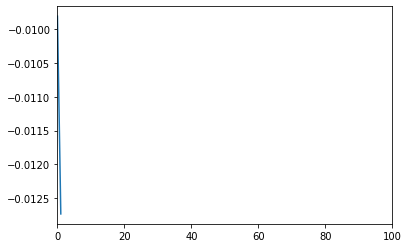

In [ ]:
plt.plot(losses)
plt.xlim(0,100)

(1.0, 100.0)

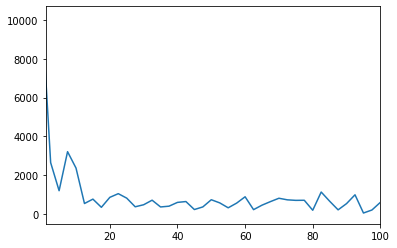

In [ ]:
plt.plot(freq.detach().cpu().numpy(), out_fft.detach().cpu().numpy())
plt.xlim(1, 100)

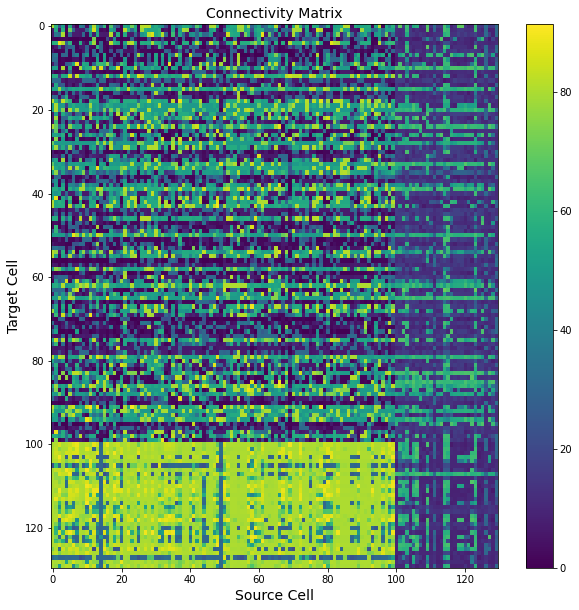

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(model.weight_matrix.detach().clamp(0,10).cpu().numpy().sum(axis=1), aspect='auto')
plt.title('Connectivity Matrix', fontsize=14)
plt.xlabel('Source Cell', fontsize=14)
plt.ylabel('Target Cell', fontsize=14)
plt.colorbar()

In [ ]:
with torch.no_grad():
    model.eval()
    input_spikes = model.init_input_spikes(n_samples=2000).to(device).requires_grad_(False)
    pred_y = model(input_spikes)
pred_y_np = pred_y.unsqueeze(2).detach().cpu().numpy()

    
    

Text(0.5, 0, 'Time (ms)')

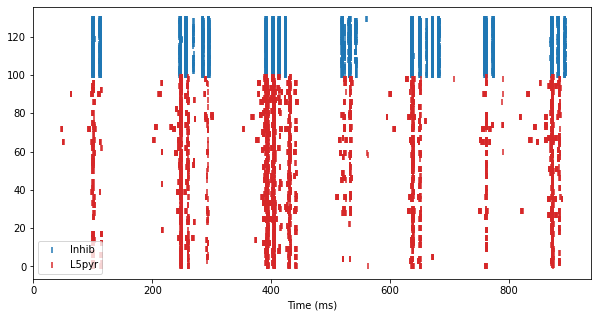

In [ ]:
cell_spikes = pred_y_np > 50.0
cell_spike_indices = np.where(cell_spikes > 0)
L5pyr_mask, inhib_mask = np.in1d(cell_spike_indices[1], model.L5Pyr_gids), np.in1d(cell_spike_indices[1], model.inhib_gids)
L5pyr_spikes = (cell_spike_indices[1][L5pyr_mask], cell_spike_indices[0][L5pyr_mask])
inhib_spikes = (cell_spike_indices[1][inhib_mask], cell_spike_indices[0][inhib_mask])

plt.figure(figsize=(10, 5))
plt.scatter(inhib_spikes[1] * dt, inhib_spikes[0], c='C0', marker='|', label='Inhib')
plt.scatter(L5pyr_spikes[1] * dt, L5pyr_spikes[0], c='C3', marker='|', label='L5pyr')
plt.xlim(0, None)
plt.legend()
plt.xlabel('Time (ms)')

In [ ]:
pred_y_np.shape

(1800, 130, 1)

In [56]:
output_size=1

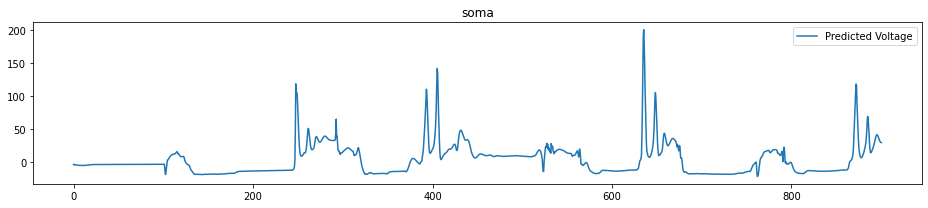

In [57]:
# output_size = len(training_set.datasets[0].vsec_names)
tvec = np.linspace(0, pred_y_np.shape[0] * dt, pred_y_np.shape[0])
plt.figure(figsize=(13, 3 * output_size))

for idx in range(output_size):
    plt.subplot(output_size, 1, idx+1)
    plt.plot(tvec, pred_y_np[:, 3, idx], color=f'C{idx}', label='Predicted Voltage')
    # plt.xlim(2000, 4000)
    plt.title(training_set.datasets[0].vsec_names[idx])
    # plt.ylim(-0.5,1.8)
plt.legend()
plt.tight_layout()

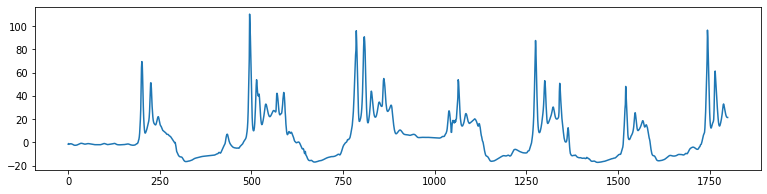

In [58]:
plt.figure(figsize=(13, 3))
plt.plot(np.mean(pred_y_np[:, :,-1], axis=1))

In [59]:
avg_soma = torch.mean(pred_y, axis=1)
out_fft = torch.fft.rfft(avg_soma).abs()
freq = torch.fft.rfftfreq(pred_y.size(0), dt / 1e3)

(1.0, 100.0)

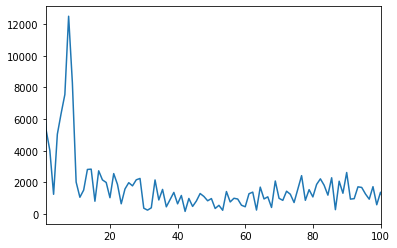

In [61]:
plt.plot(freq.detach().cpu().numpy(), out_fft.detach().cpu().numpy())
plt.xlim(1, 100)

In [ ]:
# def random_weight_matrix(n_cells, n_sec, sec_indices, src_size=100, target_size=100,
#                          src_range=None, target_range=None, max_weight=10, weight_matrix=None):
#     if weight_matrix is None:
#         weight_matrix = torch.zeros((n_cells, n_sec, n_cells)).float()

    
#     if src_range is None:
#         src_range = list(range(n_cells))

#     if target_range is None:
#         target_range = list(range(n_cells))

#     src_gid_list = np.random.choice(src_range, size=src_size, replace=False)
#     for src_gid in src_gid_list:
#         target_gid_list = np.random.choice(target_range, size=target_size, replace=False)
#         for target_gid in target_gid_list:
#             # print(weight_matrix)
#             weight_matrix[target_gid, sec_indices, src_gid] += np.random.uniform(0,max_weight)
#     return weight_matrix

# weight_matrix = random_weight_matrix(n_cells=n_cells, n_sec=L5pyr_model.input_size, sec_indices=prox_indices,
#                                      src_size=n_L5Pyr, target_size=5, src_range=L5pyr_gids)
                                     
# weight_matrix = random_weight_matrix(n_cells=n_cells, n_sec=L5pyr_model.input_size, sec_indices=inhib_indices,
#                                      src_size=n_inhib, target_size=100, src_range=inhib_gids, weight_matrix=weight_matrix)